## Import libraries

In [2]:
import os
import sys

import pandas as pd
import geopandas as gpd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns

from pandas.api.types import CategoricalDtype

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

module_path = os.path.abspath(os.path.join('../../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

/usr/local/python/lib/python3.10/site-packages/osmnx/utils.py:192: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  warnings.warn(


## Notebook config

In [3]:
# Desired damn name ('presa_laboca', 'presa_cerroprieto', 'presa_elcuchillo')
city = 'presa_laboca'

# Analysed hex resolution
r = 12

# Analysis name
index_analysis = 'ndwi'

# Analysed raster data from local directory:
tmp_dir = f'../../../data/processed/tmp_{index_analysis}/'

## Data download

### Data download - Raster Analysis Data

Analized data

In [4]:
#Load data
analysed_raster =gpd.read_file(tmp_dir+'local_save/'+f'{city}_{index_analysis}_HexRes{r}_.geojson')

#Show
print(analysed_raster.shape)
analysed_raster.head(2)

(36345, 11)


,hex_id,res,ndwi_mean,ndwi_std,ndwi_median,ndwi_max,ndwi_min,ndwi_diff,ndwi_tend,city,geometry
0,8c48a2c48393bff,12,0.535006,0.35910,0.573144,0.988064,0.147519,0.840545,-0.006303,presa_laboca,"POLYGON ((-100.13353 25.41407, -100.13343 25.4..."
1,8c48a2c484f31ff,12,-0.536730,0.12981,-0.571273,-0.418482,-0.662224,0.243741,0.002016,presa_laboca,"POLYGON ((-100.12104 25.41152, -100.12094 25.4..."


Complete dataset

In [5]:
#Load data
raster_dataset = pd.read_csv(tmp_dir+'local_save/'+f'{city}_{index_analysis}_HexRes{r}_.csv')

#Show
print(raster_dataset.shape)
raster_dataset.head(2)

(3052980, 7)


,Unnamed: 0,hex_id,res,ndwi,month,year,city
0,0,8c48a2c48393bff,12,0.636882,1,2016,presa_laboca
1,1,8c48a2c484f31ff,12,-0.614095,1,2016,presa_laboca


In [6]:
raster_dataset = raster_dataset.drop(columns=['Unnamed: 0'])
raster_dataset.head(2)

,hex_id,res,ndwi,month,year,city
0,8c48a2c48393bff,12,0.636882,1,2016,presa_laboca
1,8c48a2c484f31ff,12,-0.614095,1,2016,presa_laboca


## Data treatment

Data treatment - Create datetime data

In [7]:
#Creates datetime data by adding month (string) + / + year (string)
raster_dataset['date'] = pd.to_datetime(raster_dataset['month'].astype(str) + '/' + raster_dataset['year'].astype(str))

#Strips the day, leaving month and year
raster_dataset['date'] = raster_dataset['date'].apply(lambda x: x.strftime('%Y-%m'))

#Show
print(raster_dataset.shape)
raster_dataset.head(2)

(3052980, 7)


,hex_id,res,ndwi,month,year,city,date
0,8c48a2c48393bff,12,0.636882,1,2016,presa_laboca,2016-01
1,8c48a2c484f31ff,12,-0.614095,1,2016,presa_laboca,2016-01


Data treatment - Create raster categories

In [8]:
# Creating vegetation categories
raster_dataset['ndwi_category'] = np.nan

raster_dataset.loc[raster_dataset.ndwi>=0.2 , 'ndwi_category'] = 'Water surface'        
raster_dataset.loc[(raster_dataset.ndwi>=0.0)&
             (raster_dataset.ndwi<0.2), 'ndwi_category'] = 'Flooding, humidity'
raster_dataset.loc[(raster_dataset.ndwi>=-0.3)&
             (raster_dataset.ndwi<0.0), 'ndwi_category'] = 'Moderate drought, non-aqueous surfaces'
raster_dataset.loc[(raster_dataset.ndwi<-0.3), 'ndwi_category'] = 'Drought, non-aqueous surfaces'

# Ordering data
categories = ['Drought, non-aqueous surfaces', 'Moderate drought, non-aqueous surfaces', 'Flooding, humidity', 'Water surface']
raster_dataset['ndwi_category'] = pd.Categorical(raster_dataset['ndwi_category'], categories=categories, ordered=True)

#Show
print(raster_dataset.shape)
raster_dataset.head(2)

(3052980, 8)


,hex_id,res,ndwi,month,year,city,date,ndwi_category
0,8c48a2c48393bff,12,0.636882,1,2016,presa_laboca,2016-01,Water surface
1,8c48a2c484f31ff,12,-0.614095,1,2016,presa_laboca,2016-01,"Drought, non-aqueous surfaces"


## Data analysis

### Data analysis - Historical behaviour

Calculate basics for analysis

In [40]:
#Calculate average hex area according to resolution and location (Not currently in use)
#gdf = analysed_raster.to_crs("EPSG:6372")
#gdf['area'] = gdf.area
#average_hexarea = gdf.area.mean()
#print(average_hexarea)

#Calculate average hex area according to resolution and location
available_dates = len(raster_dataset.date.unique())
print(available_dates)

84


Calculate historical area behaviour

In [100]:
#Create DataFrame
cols = ['date', 'ndwi_category', 'hexcount','percentage']
historical_behaviour = pd.DataFrame(columns=cols, index=range(available_dates*4)) # rows = available dates * available categories
historical_behaviour['city'] = city

#Loop for each date
count = 0

for date in raster_dataset.date.unique():
    complete_bydate = raster_dataset.loc[(raster_dataset.date == date)]
    date_count = complete_bydate.shape[0]
    
    #Loop for each raster category
    for cat in categories:
        complete_bydate_cat = complete_bydate.loc[(complete_bydate.ndwi_category == cat)]
        cat_count = complete_bydate_cat.shape[0]
        
        #Register data in DataFrame
        historical_behaviour.loc[count].date = date
        historical_behaviour.loc[count].ndwi_category = cat
        historical_behaviour.loc[count].hexcount = cat_count
        historical_behaviour.loc[count].percentage = (cat_count/date_count)*100     
        
        #Next row in DataFrame
        count = count + 1
        
#Save month data
historical_behaviour['month'] = historical_behaviour['date'].apply(lambda x: pd.Timestamp(x).month)

#Show
print(historical_behaviour.shape)
historical_behaviour

(336, 6)


,date,ndwi_category,hexcount,percentage,city,month
0,2016-01,"Drought, non-aqueous surfaces",22175,61.012519,presa_laboca,1
1,2016-01,"Moderate drought, non-aqueous surfaces",3153,8.675196,presa_laboca,1
2,2016-01,"Flooding, humidity",354,0.973999,presa_laboca,1
3,2016-01,Water surface,10663,29.338286,presa_laboca,1
4,2016-02,"Drought, non-aqueous surfaces",20831,57.314624,presa_laboca,2
...,...,...,...,...,...,...
331,2022-11,Water surface,232,0.638327,presa_laboca,11
332,2022-12,"Drought, non-aqueous surfaces",17127,47.123401,presa_laboca,12
333,2022-12,"Moderate drought, non-aqueous surfaces",9209,25.337736,presa_laboca,12
334,2022-12,"Flooding, humidity",9883,27.192186,presa_laboca,12


Create series of data

In [71]:
columns_tokeep = ['date','percentage']

water = historical_behaviour.loc[(historical_behaviour.ndwi_category == 'Water surface')]
water = water.reset_index()
water = water[columns_tokeep]

flood = historical_behaviour.loc[(historical_behaviour.ndwi_category == 'Flooding, humidity')]
flood = flood.reset_index()
flood = flood[columns_tokeep]

moderate = historical_behaviour.loc[(historical_behaviour.ndwi_category == 'Moderate drought, non-aqueous surfaces')]
moderate = moderate.reset_index()
moderate = moderate[columns_tokeep]

drought = historical_behaviour.loc[(historical_behaviour.ndwi_category == 'Drought, non-aqueous surfaces')]
drought = drought.reset_index()
drought = drought[columns_tokeep]

Plot

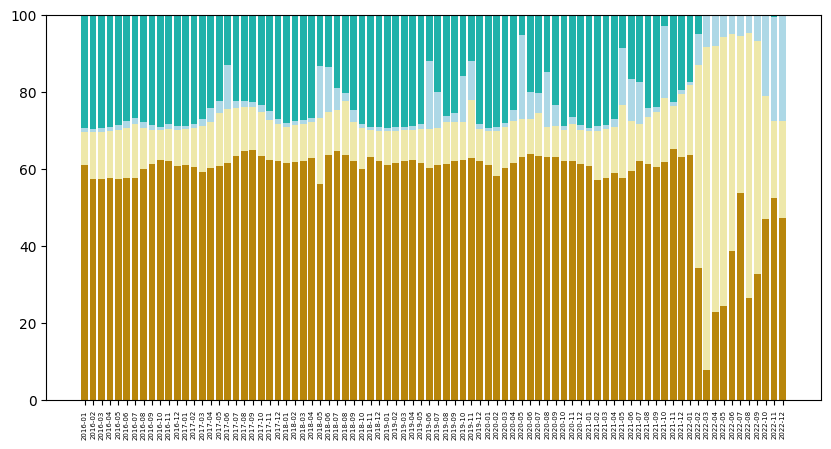

In [96]:
x = water['date']
y4 = water['percentage']
y3 = flood['percentage']
y2 = moderate['percentage']
y1 = drought['percentage']

fig, ax = plt.subplots(figsize=(10,5))

plt.bar(x, y1, color='darkgoldenrod')
plt.bar(x, y2, bottom=y1, color='palegoldenrod')
plt.bar(x, y3, bottom=y1+y2, color='lightblue')
plt.bar(x, y4, bottom=y1+y2+y3, color='lightseagreen')

# Format - x ticks
# Rotate ticks
x = plt.gca().xaxis
for item in x.get_ticklabels():
    item.set_rotation(90)
    item.set_size(5)

### Data analysis - Seasonal (by month) behaviour

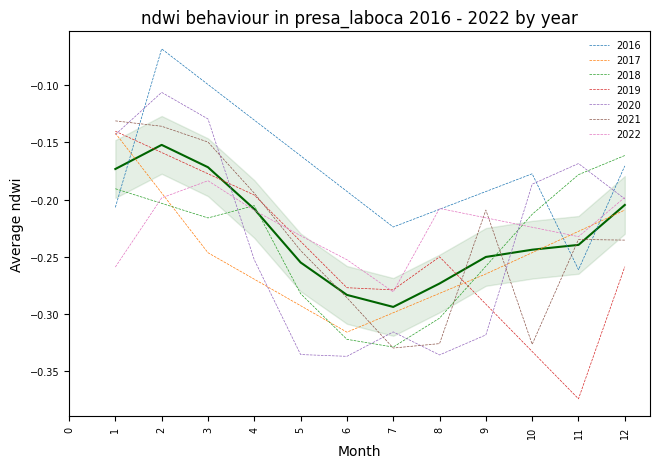

In [125]:
columns_tokeep = ['date','month','percentage']

# ---------- Plotting whole data by month (main line) ----------
# DATA
complete_bymonth = raster_dataset.groupby('month').agg({'month':np.mean,'ndwi':np.mean})

# ------- DATA AND CONFIDENCE INTERVAL PLOT -------
#Confidence interval data
x = complete_bymonth.month
y = complete_bymonth.ndwi
ci = 1.96 * np.std(y)/np.sqrt(len(x))

#Plot
fig, ax = plt.subplots(figsize=(7.5,5))
ax.plot(x,y, color = 'darkgreen')
ax.fill_between(x, (y-ci), (y+ci), color='darkgreen', alpha=.1)



# ---------- MONTHLY DATA (dotted lines) ----------

# Find all data years
available_years = list(raster_dataset['year'].unique())

#Iterate over each year
for current_year in available_years:
    #Isolating df
    current_raster_dataset = raster_dataset.loc[(raster_dataset.year == current_year)]
    #Grouping by month    
    data_bymonth = current_raster_dataset.groupby('month').agg({'ndwi':np.mean})
    #Plotting
    plt.plot(data_bymonth, '--', linewidth = 0.5, label=current_year);
    
    
# ---------- FORMAT ----------
# Format - Titles
plt.title('ndwi behaviour in {} 2016 - 2022 by year'.format(city))
plt.xlabel('Month')
plt.ylabel('Average ndwi')

# Format - x ticks
# Tag all 12 months
plt.xticks(np.arange(0, 13))
# Rotate ticks
x = plt.gca().xaxis
for item in x.get_ticklabels():
    item.set_rotation(90)
    item.set_size(7)

# Format - y ticks
y = plt.gca().yaxis
for item in y.get_ticklabels():
    item.set_size(7)

# Format - Legend
plt.legend(frameon=False,
           loc=1, 
           fontsize = 7)